# RFMove Quick Start

In [1]:
import pybullet
import sys
# You do not need to append "../install/lib" on search path
# if moveit_noros shared library has been installed in to your 
# python site-packages directory.
# sys.path.append("../install/lib")
import moveit_noros as moveit
import pybullet_data
import time
import numpy as np
import threading
import matplotlib.pyplot as plt

## Initialize Pybullet
We use [pybullet](https://github.com/bulletphysics/bullet3) as our test environment. Please refer to [pybullet quickstart guide](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit) for the usage of pybullet.

In [2]:
pybullet.connect(pybullet.GUI)
pybullet.setRealTimeSimulation(1)
pybullet.setGravity(0,0,-10)

### Load Robot Into Pybullet

In [3]:
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
planeId = pybullet.loadURDF("plane.urdf")

pybullet.setAdditionalSearchPath("../resources")
startPos = [0,0,0]
startOrientation = pybullet.getQuaternionFromEuler([0, 0, 0])
robot_id = pybullet.loadURDF("pr2.urdf", startPos, startOrientation, useFixedBase=1)

## Initialize Moveit
### Load Robot Into Moveit
First we need to create a RobotModelLoader through `createRobotModelLoaderFromFile`. RobotModelLoader maintains `RobotModel` and provide shared pointers as views of it. It can also used to generate `RobotState` and `PlanningScene`.

In [4]:
robot_loader = moveit.createRobotModelLoaderFromFile("../resources/pr2.urdf", "../resources/pr2_config/pr2.srdf")

Then we need to load several configurations into RobotModelLoader including
- JointLimits: Configuration for robot limitations such as position and velocity bounds. It can be loader through `RobotModelLoader.loadJointLimits(JointLimitsLoader)`
- Kinematics configuration: Configuration for kinematics solvers. It can be loaded through `RobotModelLoader.loadKinematicsSolvers(KinematicsLoader)`
- Planner configuration: Configuration for motion planner. PlannerConfiguration works as a parameter when create planner.

In [5]:
joint_limits_loader = moveit.createJointLimitsLoaderFromFile("../resources/pr2_config/joint_limits.yaml")
robot_loader.loadJointLimits(joint_limits_loader)

kinematic_solver_loader = moveit.createKinematicsLoaderFromFile("../resources/pr2_config/kinematics.yaml")
robot_loader.loadKinematicsSolvers(kinematic_solver_loader)

planner_config = moveit.createPlannerConfigurationFromFile("../resources/pr2_config/ompl_planning.yaml")

### Create Planner and PlanningScene
Planner is the motion planning solver. PlanningScene matains the robot and world info.

In [6]:
robot_model = robot_loader.getModel()
planner = moveit.PlannerManager(robot_model, planner_config)
planning_scene = robot_loader.newPlanningScene()

### Create Pybullet Hardware Accessor
Robot controller is implemented within our moveit_noros shared library. The controller can be used to control different hardwares as long as the hardware has implemented the common `HardwareInterface`.

When it comes to pybullet, we also treat it as a hardware and implement `PybulletHardware` inherited from `HardwareInterface`. However, the implementation is very intuitively which accesses the pybullet python methods directly.

In order to create a PybulletHardware, we need to provide pybullet python module directly together with the bullet3 bodyUniqueId of robot, which is the return value of `pybullet.loadURDF`.

In [7]:
bullet_hardware = moveit.PybulletHardware(pybullet, robot_id)

### Create PlanningSceneHelper
PlanningSceneHelper has the following functionality:
- Synchronize robot state between moveit planning scene and simulated / real robot hardware.
- Synchronize world information between moveit planning scene and simulated / real world.

In [8]:
scene_helper = moveit.PlanningSceneHelper(bullet_hardware, planning_scene)

PlanningSceneHelper provides two different robot state synchronization method
- `sync()`: Change the robot state within moveit PlanningScene the same as pybullet hardware.
- `resync()`: Change the robot state (joint position only) within pybullet the same as PlanningScene current robot state.

The first thing we need to do after creation of PlanningSceneHelper is call `PlanningSceneHelper.reset()` which does two important setting
- Set the current robot state within PlanningScene as default state.
- Set all joint positions within pybullet the same as PlanningScene, call `resync()` in other words.

In [9]:
scene_helper.reset()

However, you may find out that the robot in pybullet GUI is non draggable after the calling of `PlanningSceneHelper.reset()` or `resync()`. That is because giant force is applied on every robot joint. You can call `PybulletHardware.free()` to make it draggable again.

If you still can not drag the robot link through your mouse, try to press `ALT` or `CTRL`.

In [10]:
bullet_hardware.free()

`free()` can also have one parameter which specify the force value applied on each joint. You can try to give it a small value (default is 200).

In [11]:
bullet_hardware.free(1)

In [12]:
scene_helper.reset()

## Solve Inverse Kinematics
Inverse kinematics means to calculate the position of each joint according to the position of tip link. Solving IK does not need any planner or planning scene. It can be done through `RobotState.setFromIK()` directly.

In order to test IK solving, we need to specify the JointModelGroup we calculate for. JointModelGroup is the basic unit to do kinematics calculation and motion planning. It is defined within the moveit `srdf` file.

In [13]:
PLANNING_GROUP = "left_arm"
joint_model_group = robot_model.getJointModelGroup(PLANNING_GROUP)

base_link = joint_model_group.base_link
tip_link = joint_model_group.tip_link
print("joint model group:\t%s" % joint_model_group)
print("base link:\t %s" % base_link)
print("tip link:\t %s" % tip_link)

joint model group:	left_arm
base link:	 l_shoulder_pan_link
tip link:	 l_wrist_roll_link


Any robot state can be used to compute IK. Here we use two different robot state:
- One random state, which generates valid random robot position.
- One control state. We use the tip link position generated by random state as input, set the control state by IK solving.

In [14]:
random_state = robot_loader.newRobotState()
control_state = robot_loader.newRobotState()
random_state.setToDefaultValues()
control_state.setToDefaultValues()

We first set random_state to a valid random position and fetch its tip link transform. However, here we only want to solve IK for `left_arm`, so we use joint_model_group as one parameter. `RobotState.setToRandomPositions()` can also take no parameter which means set all joints to a random position.

**Note:** Transformation here is represented through Eigen Affine Matrix.

In [15]:
random_state.setToRandomPositions(joint_model_group)
tip_transform = random_state.getGlobalLinkTransform(tip_link)
print(tip_transform.__repr__())

<EigenAffine3d from Eigen::Affine3d>
Translation:
 0.576519
-0.264793
  1.08932
Rotation:
 -0.229529   0.259877  -0.937966
0.00702307  -0.963228  -0.268594
 -0.973277 -0.0682375   0.219263



Now we set control state through IK solving.

In [16]:
success = control_state.setFromIK(joint_model_group, tip_transform)
print("IK FOUND" if success else "CAN NOT FIND IK")

IK FOUND


We can visualize the IK solution by control pybullet model move to control_state. Here we use `JointModelGroup.getJointModelNames()` to fetch the name of all joints. And use `PybulletHardware.getJointIndex(joint_name)` to fetch the joint index of specific joint within pybullet.

In [17]:
for joint_name in joint_model_group.getJointModelNames():
    joint_index = bullet_hardware.getJointIndex(joint_name)
    if joint_index > 0:
        pybullet.setJointMotorControl2(robot_id, 
                                       joint_index, 
                                       pybullet.POSITION_CONTROL, 
                                       targetPosition = control_state.getJointPosition(joint_name),
                                       maxVelocity = 3)
    else:
        print("Can not find joint " + joint_name)

Here we use a small thread to repeat the above process.

In [18]:
class randomIK(threading.Thread):
    def __init__(self):
        self.stop = False
        threading.Thread.__init__(self)
    def run(self):
        while True:
            random_state.setToRandomPositions(joint_model_group)
            tip_transform = random_state.getGlobalLinkTransform(tip_link)
            if(control_state.setFromIK(joint_model_group, tip_transform)):
                for joint_name in joint_model_group.getJointModelNames():
                    joint_index = bullet_hardware.getJointIndex(joint_name)
                    if joint_index > 0:
                        pybullet.setJointMotorControl2(robot_id, 
                                                       joint_index, 
                                                       pybullet.POSITION_CONTROL, 
                                                       targetPosition = control_state.getJointPosition(joint_name),
                                                       maxVelocity = 3)
                    else:
                        print("Can not find joint " + joint_name)
            if self.stop:
                break
            time.sleep(2)
        print("Thread end")

In [19]:
randomIK_thread = randomIK()
randomIK_thread.start()

In [20]:
randomIK_thread.stop = True
randomIK_thread.join()
scene_helper.reset()

Thread end


## Pose Goal Motion Plan
The most motion plan task is move the robot to a specific pose. Here we use planner to set the tip link of joint_model_goup to specific pose. This may sounds same as inverse kinematics. But we can get a whole moveing trajectory with the help of planner.

Remember that we have created our planner and planning scene before.

In [21]:
print(planner.__repr__())
print(planning_scene.__repr__())
print(scene_helper.__repr__())

### Generate Motion Plan Request
We still use random_state to generate a random tip_link transform.

In [22]:
random_state.setToRandomPositions(joint_model_group)
tip_transform = random_state.getGlobalLinkTransform(tip_link)
print(tip_transform.__repr__())

<EigenAffine3d from Eigen::Affine3d>
Translation:
  0.663742
0.00204982
  0.709371
Rotation:
-0.462243  0.801188 -0.380037
-0.350081  -0.55864 -0.751908
-0.814724  -0.21452  0.538708



In order to do a motion plan, we need to construct a MotionPlanRequest. The definition of MotionPlanRequest is from [ros-planning/moveit_msgs/msg/MotionPlanRequest.msg](https://github.com/ros-planning/moveit_msgs/blob/kinetic-devel/msg/MotionPlanRequest.msg).

We first create a stamped pose for tip link. `PoseStamped` need to specify the corresponding frame. All transforms fetched directly from `RobotState` is according to robot root frame. Here we want to use the joint model group base frame instead of the robot root frame. In that case, we need to compute the relative transform of tip_link according to the group base frame.

`RobotState.linkRelativeTransform()` can calculate the relative transform of link according to specific frame.

When creating PoseStamped, the rotation should be in quaternion form.

In [23]:
base_frame = joint_model_group.base_frame
relative_transform = random_state.linkRelativeTransform(tip_link, base_frame)
print(relative_transform)
pose = moveit.PoseStamped(base_frame, relative_transform.translation, relative_transform.quaternion.value)

Translation:
  0.713742
0.00204982
 -0.249554
Rotation:
-0.462243  0.801188 -0.380037
-0.350081  -0.55864 -0.751908
-0.814724  -0.21452  0.538708



Create MotionPlanRequest and add a pose goal.

In [24]:
req = moveit.MotionPlanRequest(PLANNING_GROUP)
pose_goal = moveit.constructGoalConstraints(tip_link, pose, 0.01, 0.01)
req.addGoal(pose_goal)

### Solve Motion Plan Task
Create planning context for this request and solve the motion plan task use this context.

In [25]:
context = planner.getPlanningContext(planning_scene, req)
response = context.solve()

`response.trajectory` now contains the planed trajectory information. The trajectory is a list of robot state waypoints. We can vistualize this trajectory in out pybullet GUI by adding debug lines according to the tip transform of these waypoints.

**Note:** You can generate a new random position if the trajectory line is not obvious.

In [26]:
# RobotTrajectory.waypoints is a list of waypoints in the form of RobotState.
for i in range(len(response.trajectory.waypoints)-1):
    # RobotState.getGlobalLinkTransform can get the transformation affine matrix for specific link.
    # We use this method to fetch the tip link transform.
    # Note that the corresponding frame of this transformation is the root of robot model
    # which is also the origin of world frame as we load the robot at [0, 0, 0] through pybullet.loadURDF.
    state1 = response.trajectory.waypoints[i]
    state2 = response.trajectory.waypoints[i+1]
    tip_transform1 = state1.getGlobalLinkTransform(tip_link)
    tip_transform2 = state2.getGlobalLinkTransform(tip_link)
    pybullet.addUserDebugLine(tip_transform1.translation, # Starting point
                              tip_transform2.translation, # End point
                              [1, 0, 0],                  # Color in [R, G, B]
                              5,                          # Line width
                              10)                         # Life time in seconds
    

### Move Along Trajectory
In order to control robot to move along this trajectory smoothly, we still need following things:
- Time info. There is no time related info within trajectory for now, which means there is no duration and velocity info. In that case, the robot does not know when it should move to which waypoint and how fast it should be.
- Sample method. There are only several discretized waypoints. We still need a sample method that can sample trajectory information at any time point.

We propose SplineTrajectory with those capacities.

**Note:** When compute spline trajectory from robot trajectory, we always tranfer reference of robot trajectory instead of copying it. And the time information would be put int this robot trajectory directly. You can check the velue of `response.trajectory.durations` before and after the creation of SplineTrajectory.

In [27]:
spline_trajectory = moveit.computeSpline(response.trajectory)

Now we can sample trajectory info at any time point (even outside the bound of trajectory start time and end time). We propose many different sample methods for SplineTrajectory, the most important two of them is `sample_by_interval` and `sample_at_time`.

**sample_by_interval(joint_name, interval):** Sample the position and velocity of specific joint with fix time interval.

**sample_at_time(time_point):** Sample position and velocity of all joints at specific time point.

The return value of those two sample method is `PosVelAccState` whose position and velocity attributes are two double array. However, the meaning of list index is different. For **sample_by_interval**, the index means different time point. For **sample_at_time**, the index means the joint index within `SplineTrajectory.joint_names`

In [28]:
spline_trajectory.sample_by_interval(spline_trajectory.joint_names[0], 1)

<trajectory_interface::PosVelAccState<double>, SegmentState>
Position:
[ -3.79068e-05, -0.0948169, -0.237784,]
Velocity:
[ -0.0033528, -0.146849, -0.107569,]

In [29]:
spline_trajectory.sample_at_time(0.1)

<trajectory_interface::PosVelAccState<double>, SegmentState>
Position:
[ -0.000691122, 0.00171195, -0.000196211, -1.13433, 0.0069916, -1.05227, -0.00343729,]
Velocity:
[ -0.0164169, 0.0406655, -0.0046608, 0.0313236, 0.166078, -0.0538777, -0.0816493,]

Here we use matplotlib to draw the difference between RobotTrajectory and SplineTrajectory.

Position and Velocity for Joint l_shoulder_lift_joint


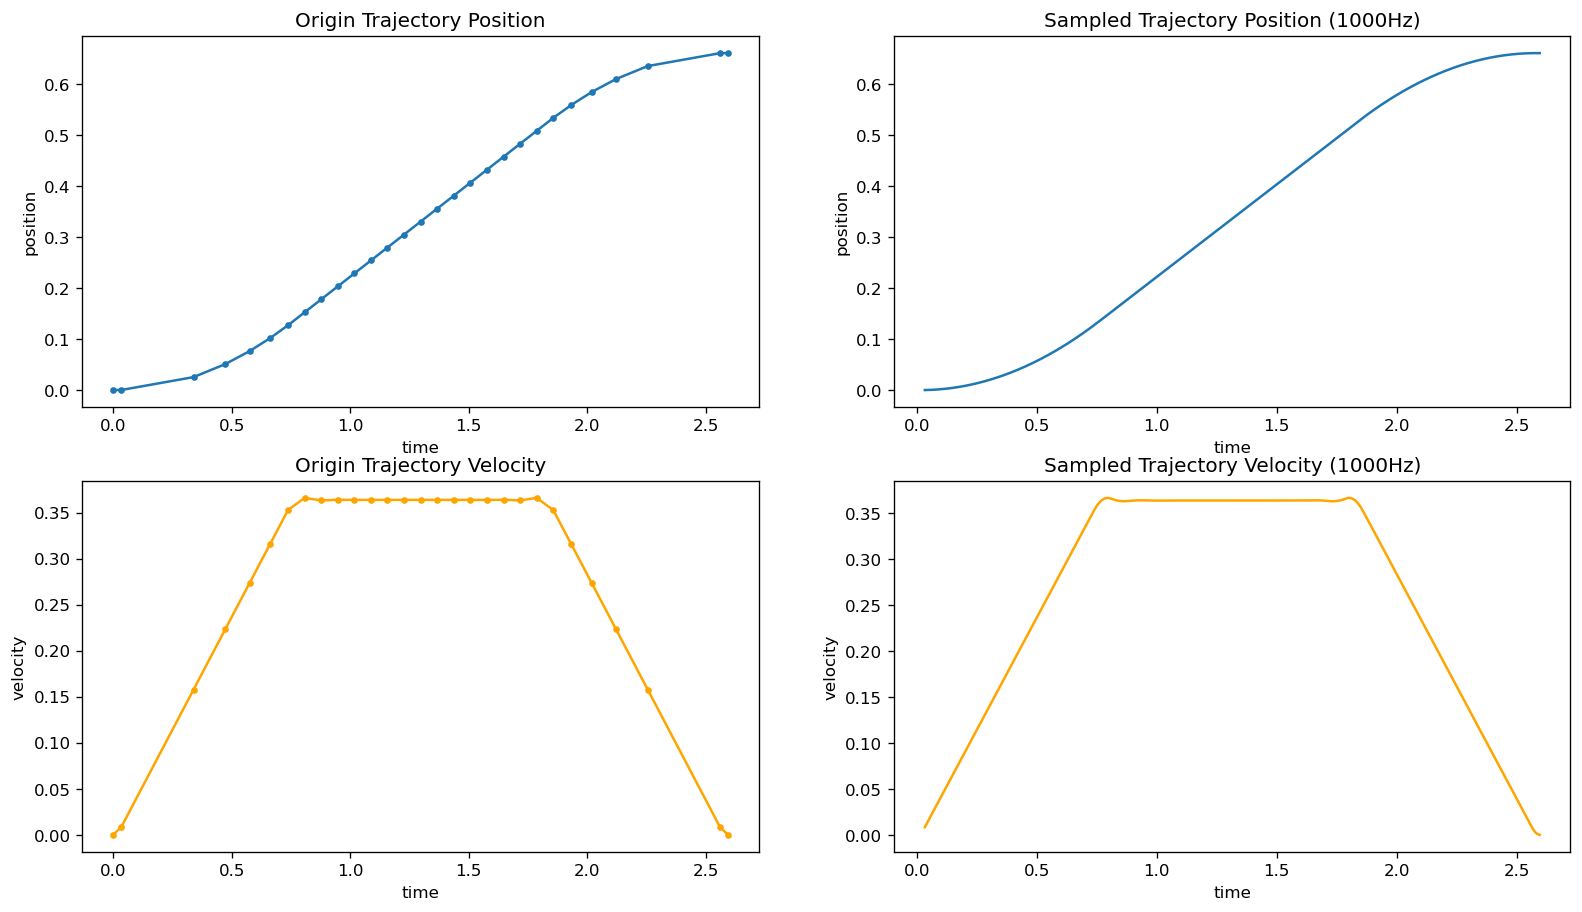

In [30]:
fig = plt.figure(num = 1, figsize=(16, 9), dpi = 120)
origin_position = fig.add_subplot(2, 2, 1)
sample_position = fig.add_subplot(2, 2, 2)
origin_velocity = fig.add_subplot(2,2,3)
sample_velocity = fig.add_subplot(2,2,4)
origin_position.set_title("Origin Trajectory Position")
origin_position.set_xlabel("time")
origin_position.set_ylabel("position")
sample_position.set_title("Sampled Trajectory Position (1000Hz)")
sample_position.set_xlabel("time")
sample_position.set_ylabel("position")
origin_velocity.set_title("Origin Trajectory Velocity")
origin_velocity.set_xlabel("time")
origin_velocity.set_ylabel("velocity")
sample_velocity.set_title("Sampled Trajectory Velocity (1000Hz)")
sample_velocity.set_xlabel("time")
sample_velocity.set_ylabel("velocity")

plt_joint_name = spline_trajectory.joint_names[1]
print("Position and Velocity for Joint " + plt_joint_name)
sample = spline_trajectory.sample_by_interval(plt_joint_name, 0.01)

# plot origin position
y_origin_position = []
for waypoint in response.trajectory.waypoints:
    y_origin_position.append(waypoint.getJointPosition(plt_joint_name))
time_stamp_origin = []
current_time_stamp_origin = 0
for duration in response.trajectory.durations:
    time_stamp_origin.append(duration + current_time_stamp_origin)
    current_time_stamp_origin+=duration
plot1 = origin_position.plot(time_stamp_origin, 
                             y_origin_position, 
                             linestyle='-', 
                             marker='o', 
                             markersize = 3)

# plot sampled position
time_stamp_sample = np.linspace(spline_trajectory.start_time, spline_trajectory.end_time, sample.position.size)
plot2 = sample_position.plot(time_stamp_sample, 
                             sample.position)

# plot origin velocity
y_origin_velocity = []
for waypoint in response.trajectory.waypoints:
    y_origin_velocity.append(waypoint.getJointVelocity(plt_joint_name))
plot3 = origin_velocity.plot(time_stamp_origin, 
                             y_origin_velocity, 
                             linestyle='-', 
                             marker='o', 
                             markersize = 3, 
                             color='orange')

# plot sampled velocity
time_stamp_sample = np.linspace(spline_trajectory.start_time, spline_trajectory.end_time, sample.velocity.size)
plot4 = sample_velocity.plot(time_stamp_sample, 
                             sample.velocity, 
                             color = 'orange')

# get tip transforms
tip_transforms = spline_trajectory.tip_transforms
#for tip in tip_transforms:
    #print(tip)

plt.show()

### Control robot By Pybullet.setJointMotorArray Directly
As long as we have SplineTrajectory, the simplest way to control pybullet robot move along this trajectory is through pybullet.POSITION_CONTROL.

In [31]:
time_interval = 0.01
joint_indices = []
for joint_name in spline_trajectory.joint_names:
    joint_indices.append(bullet_hardware.getJointIndex(joint_name))
current_time = 0.0
while current_time < spline_trajectory.end_time:
    sample_point = spline_trajectory.sample_at_time(current_time)
    pybullet.setJointMotorControlArray(robot_id,
                                       joint_indices,
                                       pybullet.POSITION_CONTROL,
                                       targetPositions = sample_point.position,
                                       targetVelocities = sample_point.velocity)
    current_time += time_interval
    time.sleep(time_interval)

In [32]:
scene_helper.reset()

### Control robot By Controller
We also provide a controller to control robot.

Controller is designed to control any hardware that implements `HardwareInterface`. Out `PybulletHardware` python accessor is just one of these hardwares.

In [33]:
controller = moveit.Controller(bullet_hardware)

In [34]:
controller.execute(spline_trajectory)

True

In [35]:
scene_helper.reset()

Here we use a small thread to repeat the motion plan and robot controll process.

In [36]:
class randomPose(threading.Thread):
    def __init__(self):
        self.stop = False
        threading.Thread.__init__(self)
    def run(self):
        while True:
            # Synchronize moveit robot state same with pybullet
            scene_helper.sync()
            
            # Generate valid random position
            random_state.setToRandomPositions(joint_model_group)
            
            # Create motion plan request
            relative_transform = random_state.linkRelativeTransform(tip_link, base_frame)
            pose = moveit.PoseStamped(base_frame, relative_transform.translation, relative_transform.quaternion.value)
            req = moveit.MotionPlanRequest(PLANNING_GROUP)
            pose_goal = moveit.constructGoalConstraints(tip_link, pose, 0.01, 0.01)
            req.addGoal(pose_goal)
            
            # Create planning context
            context = planner.getPlanningContext(planning_scene, req)
            if context is None:
                print("Context is None")
                scene_helper.reset()
                continue
                
            # Solve
            response = context.solve()
            
            if (response is None) or (response.trajectory is None):
                print("Empty Motion Plan Response")
                scene_helper.reset()
                continue
            
            # Compute spline_trajectory
            spline_trajectory = moveit.computeSpline(response.trajectory)
            
            # Show trajectory
            bullet_hardware.drawTrajectory(spline_trajectory, 
                                           spline_trajectory.end_time - spline_trajectory.start_time)
            
            # Move Robot
            controller.execute(spline_trajectory)
            
            if self.stop:
                break
            
        print("Thread end")

In [37]:
random_pose_thread = randomPose()
random_pose_thread.start()

Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
E

Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response
Empty Motion Plan Response


**To Be Continued ...**